# Introduction

We have data on a set of disruptions in which the M7 was mentioned as a potential rerouting. The M7 bus was the route that most frequently appeared in about a month's worth of service alerts related to subway disruptions. In this file, we will train a model that uses a **disruption** feature based on these disruptions. Our goal is to see whether adding this feature provides any improvement to the performance of our model. We will try two different versions of the disruption feature: one which is a binary variable indication whether a disruption is active, as well as an ordinal variabel indicating the severity of the disruption, as reported by the MTA. 

# Preparing data
## Imports

In [1]:
import pandas as pd
import passenger_pred.load as ppl
import passenger_pred.preprocess as ppp
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

## Loading m7 data

The earliest date for which we have a recorded alert is Wednesday, October 27th. The last alert we have included is from November 22nd. We will thus load m7 data from October 28th until November 21st. 

In [2]:
M7_DIR = "../data/M7/"

df_m7 = pd.read_csv(M7_DIR + "M7_20211028_20211202.csv")
df_m7.shape

(458108, 24)

## Preprocessing data

In [16]:
df_m7 = ppp.add_uid(df_m7)
df_m7 = ppp.remove_duplicate_stops(df_m7)
df_m7 = ppp.add_time_features(df_m7)
df_m7 = ppp.fill_zero_passengers(df_m7)
df_m7 = ppp.add_cycl_features(df_m7)

In [17]:
df_m7 = df_m7[df_m7.passenger_count.notna()]
df_m7 = df_m7[df_m7.passenger_count != "None"]
df_m7.shape

(103725, 36)

In [18]:
df_m7['next_stop'] = pd.Categorical(df_m7.next_stop_id, ordered=False)
df_m7['next_stop'] = df_m7['next_stop'].cat.codes
df_m7.shape

(103725, 36)

## Add disruption information
We need to load information related to the disruptions, if we would like to include this information in the m7 dataset. 

In [19]:
alert_df = pd.read_csv("../data/unplanned_alerts/m7_20211028_20211202_time.csv")
alert_df.shape

(6, 12)

In [20]:
m7_alert = alert_df.copy()
m7_alert.head()

,Unnamed: 0,startDate,direction,endDate,statusSummary,id,priority,line,creationDate,statusDescription,end_time,alert_minutes
0,0,2021-11-28 14:20:11+00:00,0,2021-11-28 15:00:02+00:00,Multiple Impacts,lmm:alert:110986,37,2,2021-11-28T08:47:53-0500,<p>There is limited [2] service between <stron...,1638111002,39.850000
1,1,2021-10-29 03:15:24+00:00,1,2021-10-29 05:00:02+00:00,Multiple Impacts,lmm:alert:104049,37,2,2021-10-28T22:25:24-0400,<p>[2] and [3] trains are delayed and/or rerou...,1635479402,104.633333
2,2,2021-11-28 15:03:05+00:00,0,2021-11-28 16:00:02+00:00,Delays,lmm:alert:111004,22,2,2021-11-28T08:47:53-0500,<p>[2] trains are running with significant del...,1638114602,56.950000
3,3,2021-10-31 17:52:09+00:00,1,2021-10-31 19:40:02+00:00,Part Suspended,lmm:alert:104663,35,3,2021-10-31T13:36:57-0400,<p>There is no [3] service between <b>Harlem-1...,1635705002,107.883333
4,4,2021-11-30 07:57:17+00:00,1,2021-11-30 08:20:01+00:00,Trains Rerouted,lmm:alert:111365,32,2,2021-11-30T02:23:57-0500,<p>[3] train service is suspended while our cr...,1638259801,22.733333


We now need to add the information from the alert `df` to the m7 `df`, if there was an alert active at the time that a record was recorded. 

In [21]:
m7_alert['startDate'] = pd.to_datetime(m7_alert.startDate, utc=True)
m7_alert['endDate'] = pd.to_datetime(m7_alert.endDate, utc=True)

df_m7['timestamp'] = pd.to_datetime(df_m7.timestamp, utc=True)

In [22]:
def alert_active(row, alert_df, boolean=True, time_column='timestamp'):
    valid_rows = alert_df[
        (alert_df.startDate < row[time_column]) &
        (row[time_column] < alert_df.endDate) 
    ]
    if boolean:
        return min(valid_rows.shape[0], 1)
    elif valid_rows.shape[0] > 0:
        return valid_rows.priority.max()
    else:
        return 0

In [23]:
df_m7['alert_ind'] = df_m7.apply(lambda x: alert_active(x, m7_alert), axis=1)
df_m7['alert_prio'] = df_m7.apply(lambda x: alert_active(x, m7_alert, boolean=False), axis=1)

In [24]:
df_m7.passenger_count = df_m7.passenger_count.astype(int)

In [25]:
df_m7.to_pickle("m7_20211028_20211202_alerts.pkl")

In [3]:
df_m7 = pd.read_pickle("m7_20211028_20211122_alerts.pkl")

In [26]:
df_m7[df_m7['alert_prio'] > 0].alert_prio.describe()

count    877.000000
mean      34.444698
std        3.607540
min       22.000000
25%       35.000000
50%       35.000000
75%       37.000000
max       37.000000
Name: alert_prio, dtype: float64

# Data analysis
A question we might first like to answer is: are average `passenger_count` values higher when an alert is active?

In [27]:
round(df_m7[df_m7.alert_ind == 1].passenger_count.mean(), 2)

8.31

In [28]:
round(df_m7[df_m7.alert_ind == 0].passenger_count.mean(), 2)

9.62

A very naive method of answering this question appears to suggest that passenger levels are indeed higher when an alert is active, although not by much. Now, it must be noted that it may be true that all these alerts were active during times of date that are always busy. Therefore, it would be better to compare the number of passengers during a time period when an alert was active, compare to a similar time of day during another day. We will do this for each of the sixteen alerts that we have included in our dataset. 

In [29]:
relevant_m7_data = df_m7[df_m7.alert_ind == 1]
non_alert_m7_data = df_m7[df_m7.alert_ind == 0]

(relevant_m7_data.shape, non_alert_m7_data.shape)

((877, 38), (102848, 38))

In [30]:
means_alert = []
means_normal = []

for i in m7_alert.index:
    row = m7_alert.loc[i]
    # print(row[['startDate', 'endDate']])
    # print("dow", row.startDate.dayofweek)
    records = relevant_m7_data[
        (relevant_m7_data.timestamp > row.startDate) &
        (relevant_m7_data.timestamp < row.endDate)
    ]
    if records.shape[0] < 5:
        continue
    mean_alert = records.passenger_count.mean()

    # find similar records
    dow = records.dow.min()
    dow_df = non_alert_m7_data[non_alert_m7_data.dow == dow]
    dow_time_df = dow_df[
        (dow_df.hour >= row.startDate.hour) &
        (dow_df.hour <= row.endDate.hour)
    ]
    print(dow_time_df.shape)
    mean_normal = dow_time_df.passenger_count.mean()
    if mean_normal is not np.nan:
        means_alert.append(mean_alert)
        means_normal.append(mean_normal)

(1268, 38)
(967, 38)
(1366, 38)
(2458, 38)
(355, 38)
(355, 38)


In [31]:
deviation = [alert - normal for alert, normal in zip(means_alert, means_normal)]
deviation

[-0.5587025099437666,
 4.031346356365567,
 -1.419716935090288,
 -1.334736239387004,
 -1.560334982870194,
 -1.1226715129486595]

<ipython-input-32-fd9cf02909a1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([None])


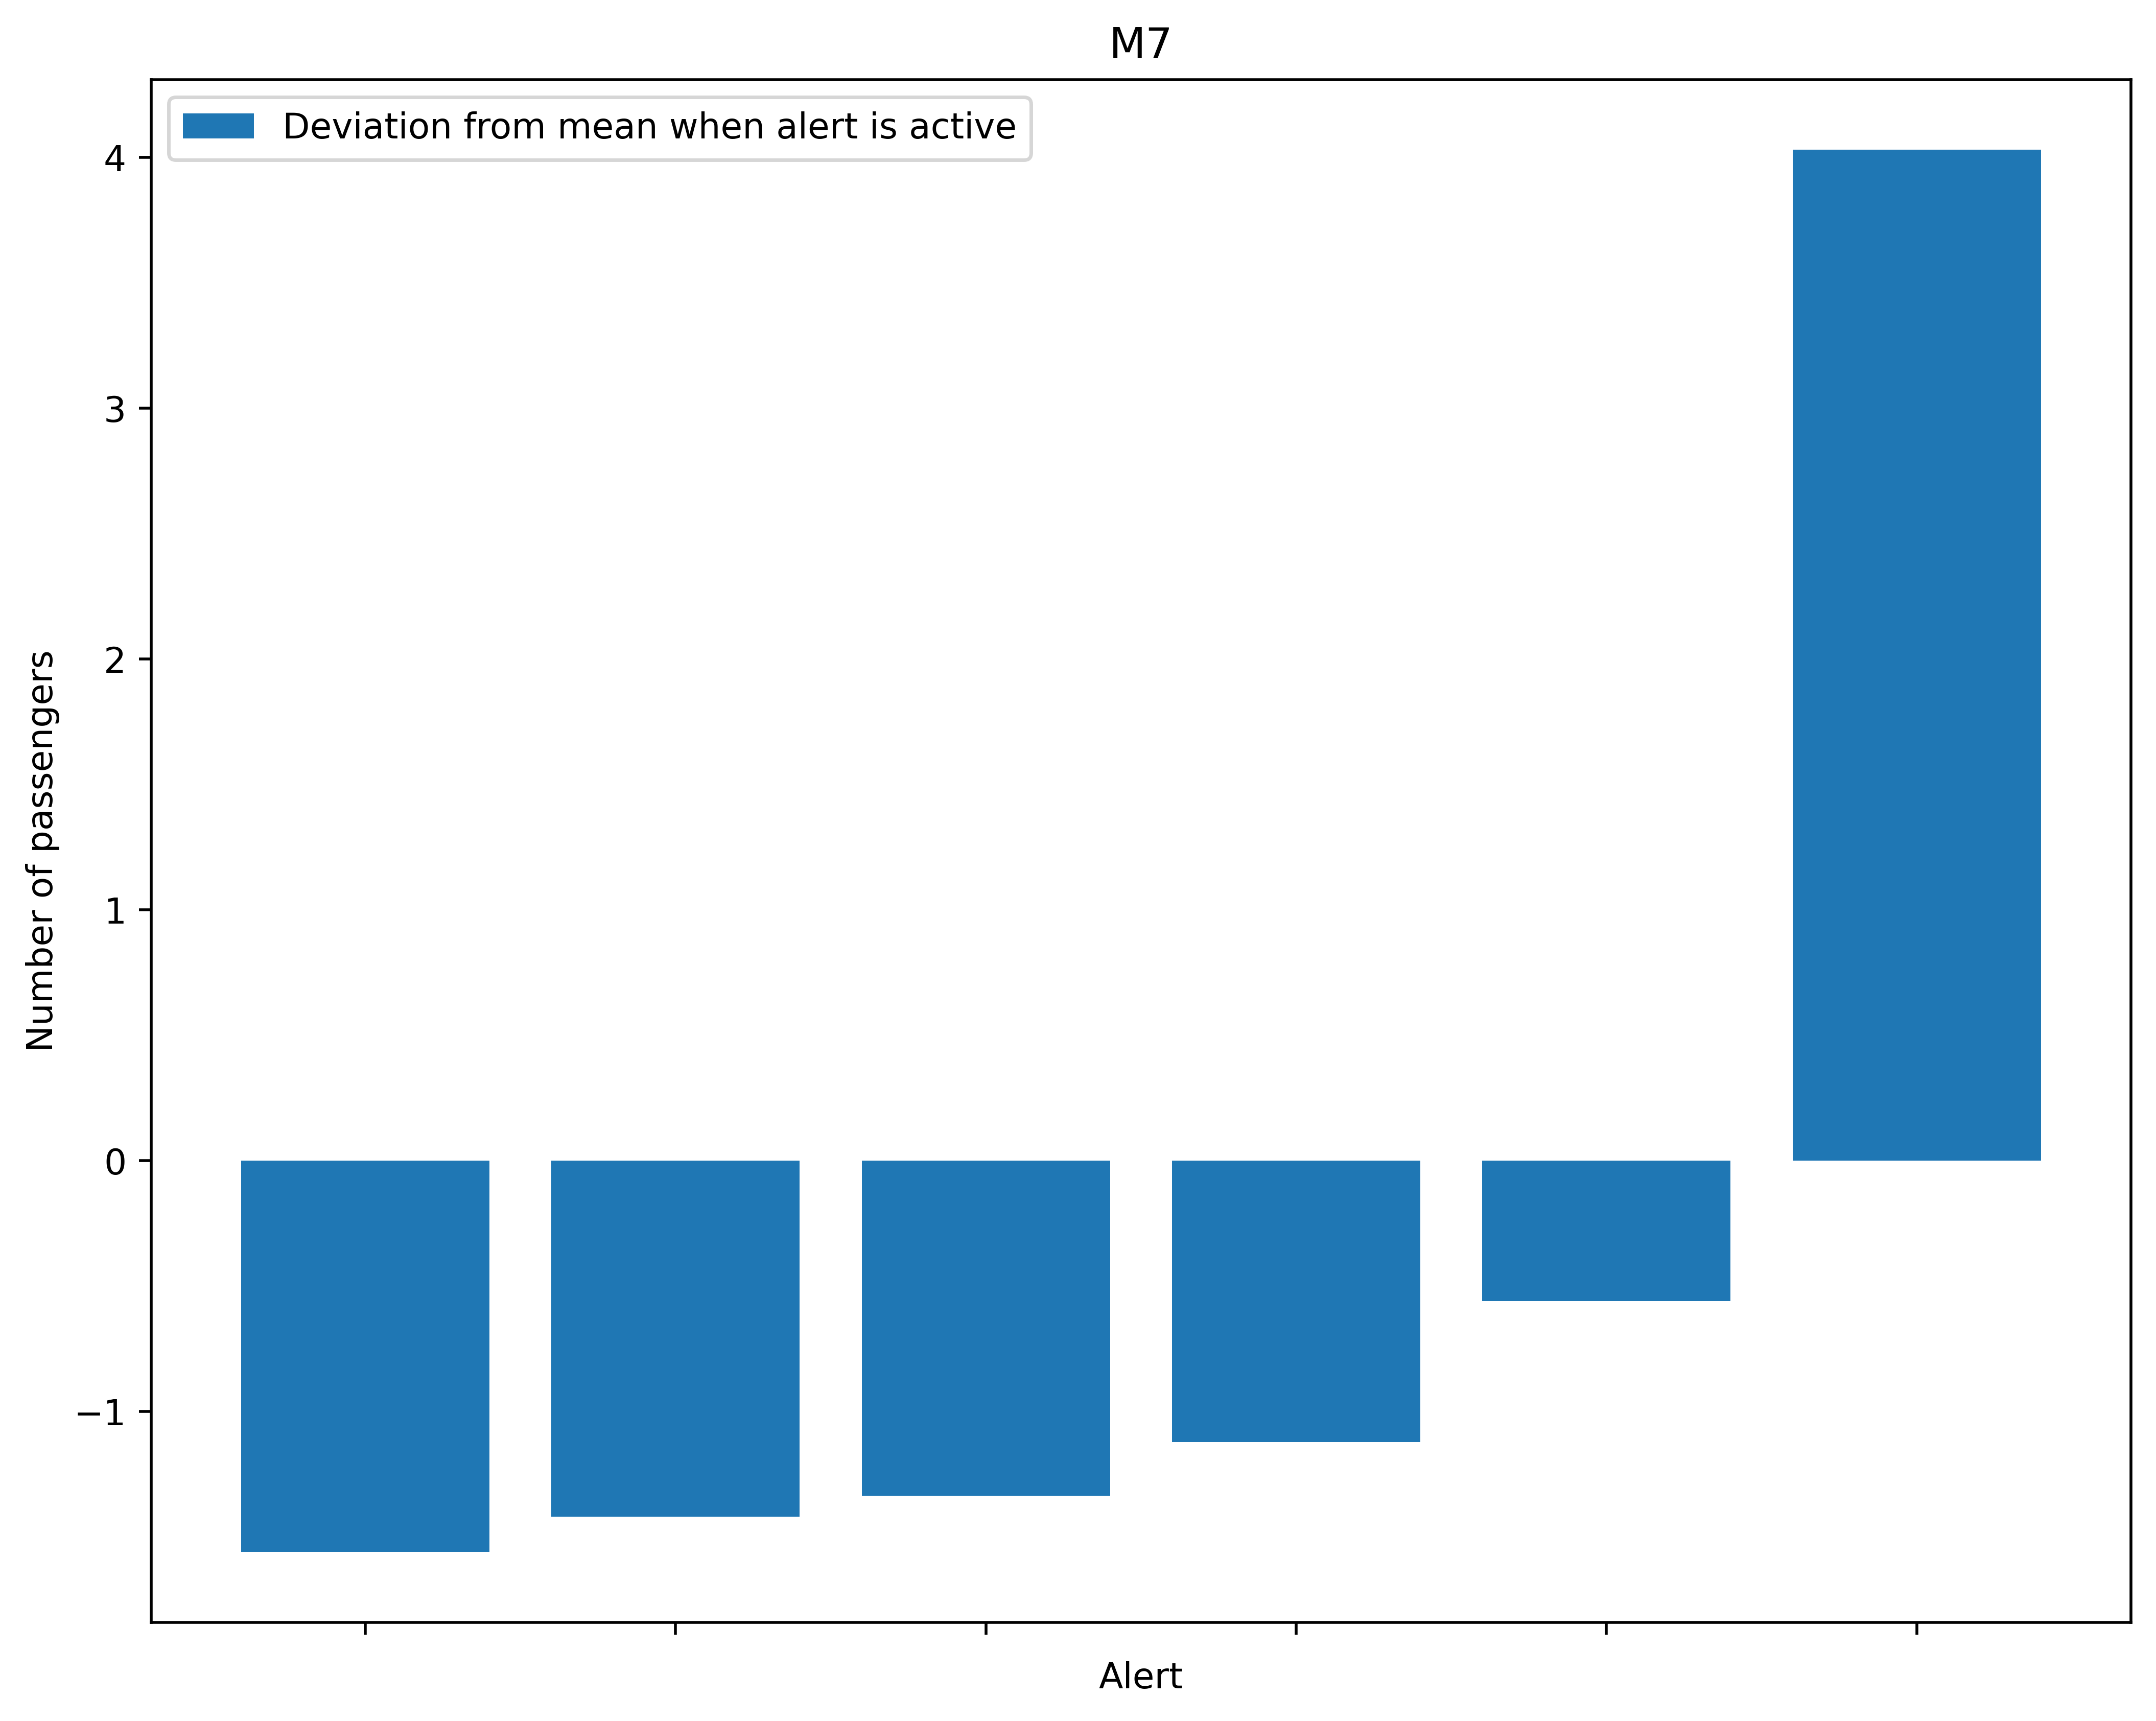

In [32]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=500)

ax.bar([i for i in range(6)], sorted(deviation), label = "Deviation from mean when alert is active",)
ax.set_title("M7")
ax.set_xlabel("Alert")
ax.set_ylabel("Number of passengers")
ax.set_xticklabels([None])
ax.legend()

# Training models
We want to train and compare three different models
- Base model (without alert information)
- Boolean alert model
- Priority alert model

We will split our data s.t. we predict on one week of data. 

In [33]:
df_m7['month'] = df_m7.timestamp_dt.dt.month

In [34]:
df_test = df_m7[
    (df_m7.day > 22) &
    (df_m7.month == 11) |
    (df_m7.day <= 2) &
    (df_m7.month == 12)
]

df_train = df_m7[~df_m7.index.isin(df_test.index)]

(df_train.shape, df_test.shape)

((79923, 38), (23802, 38))

## Feature enrichment

In [35]:
def add_averages(df_train, df_test, stop_column='next_stop'):
    mean_hour = df_train.groupby([stop_column, 'hour']).passenger_count.mean()
    mean_dow = df_train.groupby([stop_column, 'dow']).passenger_count.mean()
    mean_day = df_train.groupby([stop_column, 'day']).passenger_count.mean()
    
    df_train = df_train.join(mean_hour, on=[stop_column, 'hour'], rsuffix='_mean_hr')
    df_train = df_train.join(mean_dow, on=[stop_column, 'dow'], rsuffix='_mean_dow')
    df_train = df_train.join(mean_day, on=[stop_column, 'day'], rsuffix='_mean_day')

    df_test = df_test.join(mean_hour, on=[stop_column, 'hour'], rsuffix='_mean_hr')
    df_test = df_test.join(mean_dow, on=[stop_column, 'dow'], rsuffix='_mean_dow')
    df_test = df_test.join(mean_day, on=[stop_column, 'day'], rsuffix='_mean_day')
    return df_train, df_test

In [36]:
df_train, df_test = add_averages(df_train, df_test)

In [37]:
df_train.shape, df_test.shape

((79923, 41), (23802, 41))

## Base model

In [39]:
base_train_columns = [
    "direction",
    "next_stop",
    "lat", 
    "lon",
    "hour",
    "day",
    "dow",
    "total_minutes",
    "cos_hour",
    "cos_day",
    "cos_dow",
    "cos_total_minutes"
    # "passenger_count_mean_hr",
    # "passenger_count_mean_dow",
    # "passenger_count_mean_day",
    # "passenger_count"
]

X_train_base = df_train[base_train_columns]
y_train_base = df_train.passenger_count

X_test_base = df_test[base_train_columns]
y_test_base = df_test.passenger_count

X_train_base.shape, y_train_base.shape, X_test_base.shape, y_test_base.shape

((79923, 12), (79923,), (23802, 12), (23802,))

In [48]:
# regr_base = XGBRegressor(learning_rate=0.05, max_depth=5, objective='reg:linear', n_estimators=100, colsample_bytree=0)
regr_base = XGBRegressor(learning_rate=0.007, max_depth=4, objective='reg:linear', n_estimators=200,)

eval_set_base = [(X_train_base, y_train_base), (X_test_base, y_test_base)]

regr_base.fit(X=X_train_base, y=y_train_base, eval_metric=["rmsle", "mae"], eval_set=eval_set_base, verbose=True)

[00:05:07] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmsle:1.79035	validation_0-mae:9.17853	validation_1-rmsle:1.73155	validation_1-mae:8.91934
[1]	validation_0-rmsle:1.75184	validation_0-mae:9.11990	validation_1-rmsle:1.69467	validation_1-mae:8.86215
[2]	validation_0-rmsle:1.71564	validation_0-mae:9.06184	validation_1-rmsle:1.66004	validation_1-mae:8.80537
[3]	validation_0-rmsle:1.68154	validation_0-mae:9.00421	validation_1-rmsle:1.62757	validation_1-mae:8.74933
[4]	validation_0-rmsle:1.64927	validation_0-mae:8.94661	validation_1-rmsle:1.59674	validation_1-mae:8.69334
[5]	validation_0-rmsle:1.61845	validation_0-mae:8.89072	validation_1-rmsle:1.56735	validation_1-mae:8.63963
[6]	validation_0-rmsle:1.58922	validation_0-mae:8.83544	validation_1-rmsle:1.53949	validation_1-mae:8.58692
[7]	validation_0-rmsle:1.56163	validation_0-mae:8.78114	validation_1-rmsle:1.51356	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.007, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [49]:
y_pred_base = regr_base.predict(X_test_base)
mae_base = mean_absolute_error(y_test_base, y_pred_base)
round(mae_base, 3)

5.709

In [50]:
for title, val in zip(base_train_columns, regr_base.feature_importances_):
    print(title, round(val, 3))

direction 0.064
next_stop 0.063
lat 0.103
lon 0.128
hour 0.238
day 0.035
dow 0.101
total_minutes 0.198
cos_hour 0.0
cos_day 0.034
cos_dow 0.007
cos_total_minutes 0.028


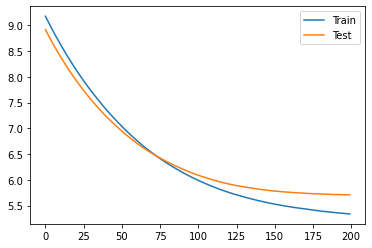

In [51]:
results = regr_base.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)


fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()

## Boolean alert model

In [53]:
bool_train_columns = [
    "direction",
    "next_stop",
    "lat", 
    "lon",
    "hour",
    "day",
    "dow",
    "total_minutes",
    "alert_ind",
    "cos_hour",
    "cos_day",
    "cos_dow",
    "cos_total_minutes"
    # "passenger_count_mean_hr",
    # "passenger_count_mean_dow",
    # "passenger_count_mean_day",
]

X_train_bool = df_train[bool_train_columns]
y_train_bool = df_train.passenger_count

X_test_bool = df_test[bool_train_columns]
y_test_bool = df_test.passenger_count

X_train_bool.shape, y_train_bool.shape, X_test_bool.shape, y_test_bool.shape

((79923, 13), (79923,), (23802, 13), (23802,))

In [61]:
# regr_bool = XGBRegressor(learning_rate=0.03, max_depth=6, objective='reg:gamma', n_estimators=400, gamma=4)
regr_bool = XGBRegressor(learning_rate=0.005, max_depth=4, objective='reg:linear', n_estimators=300)

eval_set_bool = [(X_train_bool, y_train_bool), (X_test_bool, y_test_bool)]

regr_bool.fit(X=X_train_bool, y=y_train_bool, eval_metric=["rmsle", "mae"], eval_set=eval_set_bool, verbose=True)

[00:06:43] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmsle:1.80185	validation_0-mae:9.19557	validation_1-rmsle:1.74257	validation_1-mae:8.93575
[1]	validation_0-rmsle:1.77361	validation_0-mae:9.15374	validation_1-rmsle:1.71551	validation_1-mae:8.89483
[2]	validation_0-rmsle:1.74661	validation_0-mae:9.11186	validation_1-rmsle:1.68968	validation_1-mae:8.85409
[3]	validation_0-rmsle:1.72078	validation_0-mae:9.07054	validation_1-rmsle:1.66495	validation_1-mae:8.81358
[4]	validation_0-rmsle:1.69601	validation_0-mae:9.02885	validation_1-rmsle:1.64127	validation_1-mae:8.77325
[5]	validation_0-rmsle:1.67226	validation_0-mae:8.98814	validation_1-rmsle:1.61867	validation_1-mae:8.73341
[6]	validation_0-rmsle:1.64925	validation_0-mae:8.94702	validation_1-rmsle:1.59669	validation_1-mae:8.69344
[7]	validation_0-rmsle:1.62726	validation_0-mae:8.90685	validation_1-rmsle:1.57596	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

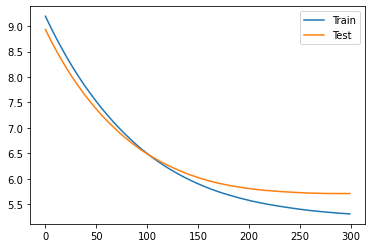

In [62]:
results = regr_bool.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)


fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()

In [63]:
y_pred_bool = regr_bool.predict(X_test_bool)
mae_bool = mean_absolute_error(y_test_bool, y_pred_bool)
round(mae_bool, 3)

5.709

In [64]:
for title, val in zip(bool_train_columns, regr_bool.feature_importances_):
    print(title, round(val, 3))

direction 0.066
next_stop 0.054
lat 0.105
lon 0.129
hour 0.243
day 0.037
dow 0.101
total_minutes 0.196
alert_ind 0.0
cos_hour 0.0
cos_day 0.035
cos_dow 0.009
cos_total_minutes 0.026


## Priority alert model

In [67]:
prio_train_columns = [
    "direction",
    "next_stop",
    "lat", 
    "lon",
    "hour",
    "day",
    "dow",
    "total_minutes",
    "alert_prio", 
    "cos_hour",
    "cos_day",
    "cos_dow",
    "cos_total_minutes"
]

X_train_prio = df_train[prio_train_columns]
y_train_prio = df_train.passenger_count

X_test_prio = df_test[prio_train_columns]
y_test_prio = df_test.passenger_count

X_train_prio.shape, y_train_prio.shape, X_test_prio.shape, y_test_prio.shape

((79923, 13), (79923,), (23802, 13), (23802,))

In [82]:
regr_prio = XGBRegressor(learning_rate=0.005, max_depth=5, objective='reg:linear', n_estimators=280)

eval_set_prio = [(X_train_prio, y_train_prio), (X_test_prio, y_test_prio)]

regr_prio.fit(X=X_train_prio, y=y_train_prio, eval_metric=["rmsle", "mae"], eval_set=eval_set_prio, verbose=True)

[00:09:36] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmsle:1.80150	validation_0-mae:9.19552	validation_1-rmsle:1.74218	validation_1-mae:8.93551
[1]	validation_0-rmsle:1.77295	validation_0-mae:9.15344	validation_1-rmsle:1.71479	validation_1-mae:8.89424
[2]	validation_0-rmsle:1.74563	validation_0-mae:9.11126	validation_1-rmsle:1.68877	validation_1-mae:8.85343
[3]	validation_0-rmsle:1.71950	validation_0-mae:9.06962	validation_1-rmsle:1.66389	validation_1-mae:8.81280
[4]	validation_0-rmsle:1.69446	validation_0-mae:9.02800	validation_1-rmsle:1.64007	validation_1-mae:8.77238
[5]	validation_0-rmsle:1.67044	validation_0-mae:8.98650	validation_1-rmsle:1.61723	validation_1-mae:8.73215
[6]	validation_0-rmsle:1.64743	validation_0-mae:8.94567	validation_1-rmsle:1.59473	validation_1-mae:8.69113
[7]	validation_0-rmsle:1.62529	validation_0-mae:8.90533	validation_1-rmsle:1.57312	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=280, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [83]:
y_pred_prio = regr_prio.predict(X_test_prio)
mae_prio = mean_absolute_error(y_test_prio, y_pred_prio)
round(mae_prio, 3)

5.62

In [95]:
for title, val in zip(bool_train_columns, regr_bool.feature_importances_):
    print(title, round(val, 3))

direction 0.066
next_stop 0.054
lat 0.105
lon 0.129
hour 0.243
day 0.037
dow 0.101
total_minutes 0.196
alert_ind 0.0
cos_hour 0.0
cos_day 0.035
cos_dow 0.009
cos_total_minutes 0.026


for title, val in zip(prio_train_columns, regr_prio.feature_importances_):
    print(title, round(val, 3))

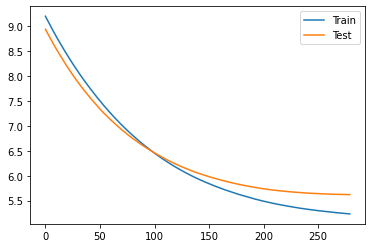

In [84]:
results = regr_prio.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()

# Result analysis

How much improvement do we find in terms of MAE?

In [52]:
round((1 - mae_bool / mae_base) * 100, 2)

0.49

In [54]:
mae_base

5.76041186195934

In [56]:
round((1 - mae_prio / mae_base) * 100, 2)

2.17

So we find 0.24% improvement when using the boolean column, and 0.61% improvement when using the priority column. These values are not particularly high. We can try to improve on these. Let's first dive a little deeper into these results. 

In [86]:
alert_index = X_test_bool[X_test_bool.alert_ind == 1].index
len(alert_index)

146

In [87]:
X_test_bool

,direction,next_stop,lat,lon,hour,day,dow,total_minutes,alert_ind,cos_hour,cos_day,cos_dow,cos_total_minutes
79923,1,73,40.776367,-73.979649,0,23,1,0,0,1.000000,-0.050649,0.5,1.000000
79924,0,115,40.821333,-73.936280,0,23,1,0,0,1.000000,-0.050649,0.5,1.000000
79925,1,77,40.748807,-73.992181,0,23,1,0,0,1.000000,-0.050649,0.5,1.000000
79926,1,112,40.775121,-73.980547,0,23,1,1,0,1.000000,-0.050649,0.5,0.999990
79927,0,107,40.739199,-73.995485,0,23,1,1,0,1.000000,-0.050649,0.5,0.999990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103720,1,93,40.757903,-73.985504,4,2,3,297,0,0.460065,0.918958,-1.0,0.270574
103721,0,91,40.753334,-73.985195,4,2,3,297,0,0.460065,0.918958,-1.0,0.270574
103722,0,96,40.788200,-73.974628,4,2,3,298,0,0.460065,0.918958,-1.0,0.266368
103723,1,75,40.754969,-73.987672,4,2,3,298,0,0.460065,0.918958,-1.0,0.266368


In [88]:
X_test_full = X_test_bool.copy()
X_test_full['y_pred_base'] = y_pred_base
X_test_full['y_pred_bool'] = y_pred_bool
X_test_full['y_pred_prio'] = y_pred_prio
X_test_full['y_test'] = y_test_base

In [89]:
X_test_full['base_error'] = X_test_full.y_test - X_test_full.y_pred_base
X_test_full['bool_error'] = X_test_full.y_test - X_test_full.y_pred_bool
X_test_full['prio_error'] = X_test_full.y_test - X_test_full.y_pred_prio

In [90]:
error_cols = ['base_error', 'bool_error', 'prio_error']

np.abs(X_test_full[error_cols]).mean()

base_error    5.70878
bool_error    5.70859
prio_error    5.61952
dtype: float32

In [91]:
np.abs(X_test_full[X_test_full.alert_ind == 1][error_cols]).mean()

base_error    2.515687
bool_error    2.539931
prio_error    2.399131
dtype: float32

In the samples where an alert is active, there is some interesting behaviour. First, the error is actually higher than the base case when using the boolean indicator. When using the priority as a feature, the result is slightly better than the base case. This is somewhat unexpected: we would have expected the indication of an alert to help in predicting better values. Let's see what has happened to the errors in the rest of the dataset. 

In [92]:
np.abs(X_test_full[X_test_full.alert_ind == 0][error_cols]).mean()

base_error    5.728487
bool_error    5.728144
prio_error    5.639397
dtype: float32

These values follow a similar trend as the ones of the full dataset. This is to be expected: after all, the alert samples make up less than 2% of the data. 

In [93]:
X_test_full['prio_improvement'] = X_test_full.prio_error - X_test_full.base_error 

Text(0.5, 0.98, 'M7 model')

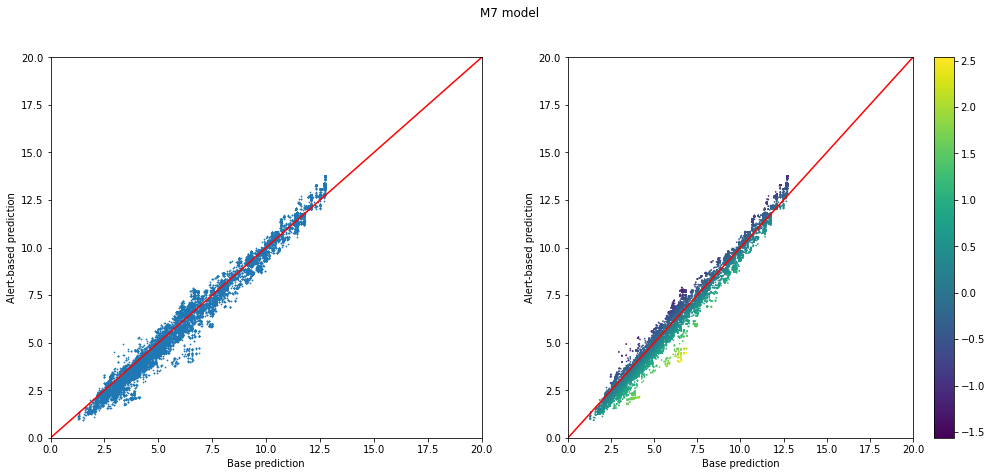

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].scatter(X_test_full.y_pred_base, X_test_full.y_pred_prio, s=0.5)
ax[0].set_xlabel("Base prediction")
ax[0].set_ylabel("Alert-based prediction")
ax[0].set_xlim(0, 20)
ax[0].set_ylim(0, 20)
ax[0].plot([0, 55], [0, 55], c='r')

im = ax[1].scatter(X_test_full.y_pred_base, X_test_full.y_pred_prio, s=0.5, c=X_test_full.prio_improvement)
ax[1].set_xlabel("Base prediction")
ax[1].set_ylabel("Alert-based prediction")
ax[1].set_xlim(0, 20)
ax[1].set_ylim(0, 20)
ax[1].plot([0, 55], [0, 55], c='r')
fig.colorbar(im, ax=ax[1])
fig.suptitle("M7 model")


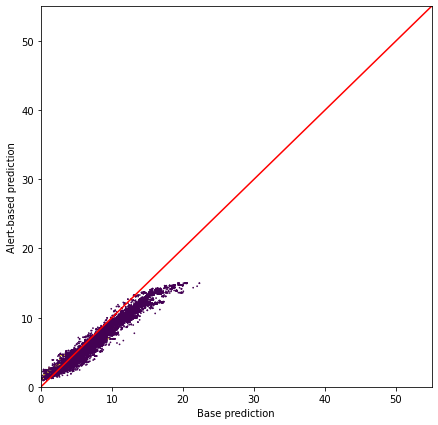

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(X_test_full.y_pred_base, X_test_full.y_pred_prio, s=0.5, c=X_test_full.alert_ind)
ax.set_xlabel("Base prediction")
ax.set_ylabel("Alert-based prediction")
ax.set_xlim(0, 55)
ax.set_ylim(0, 55)
ax.plot([0, 55], [0, 55], c='r')

Text(0.5, 1.0, 'M7')

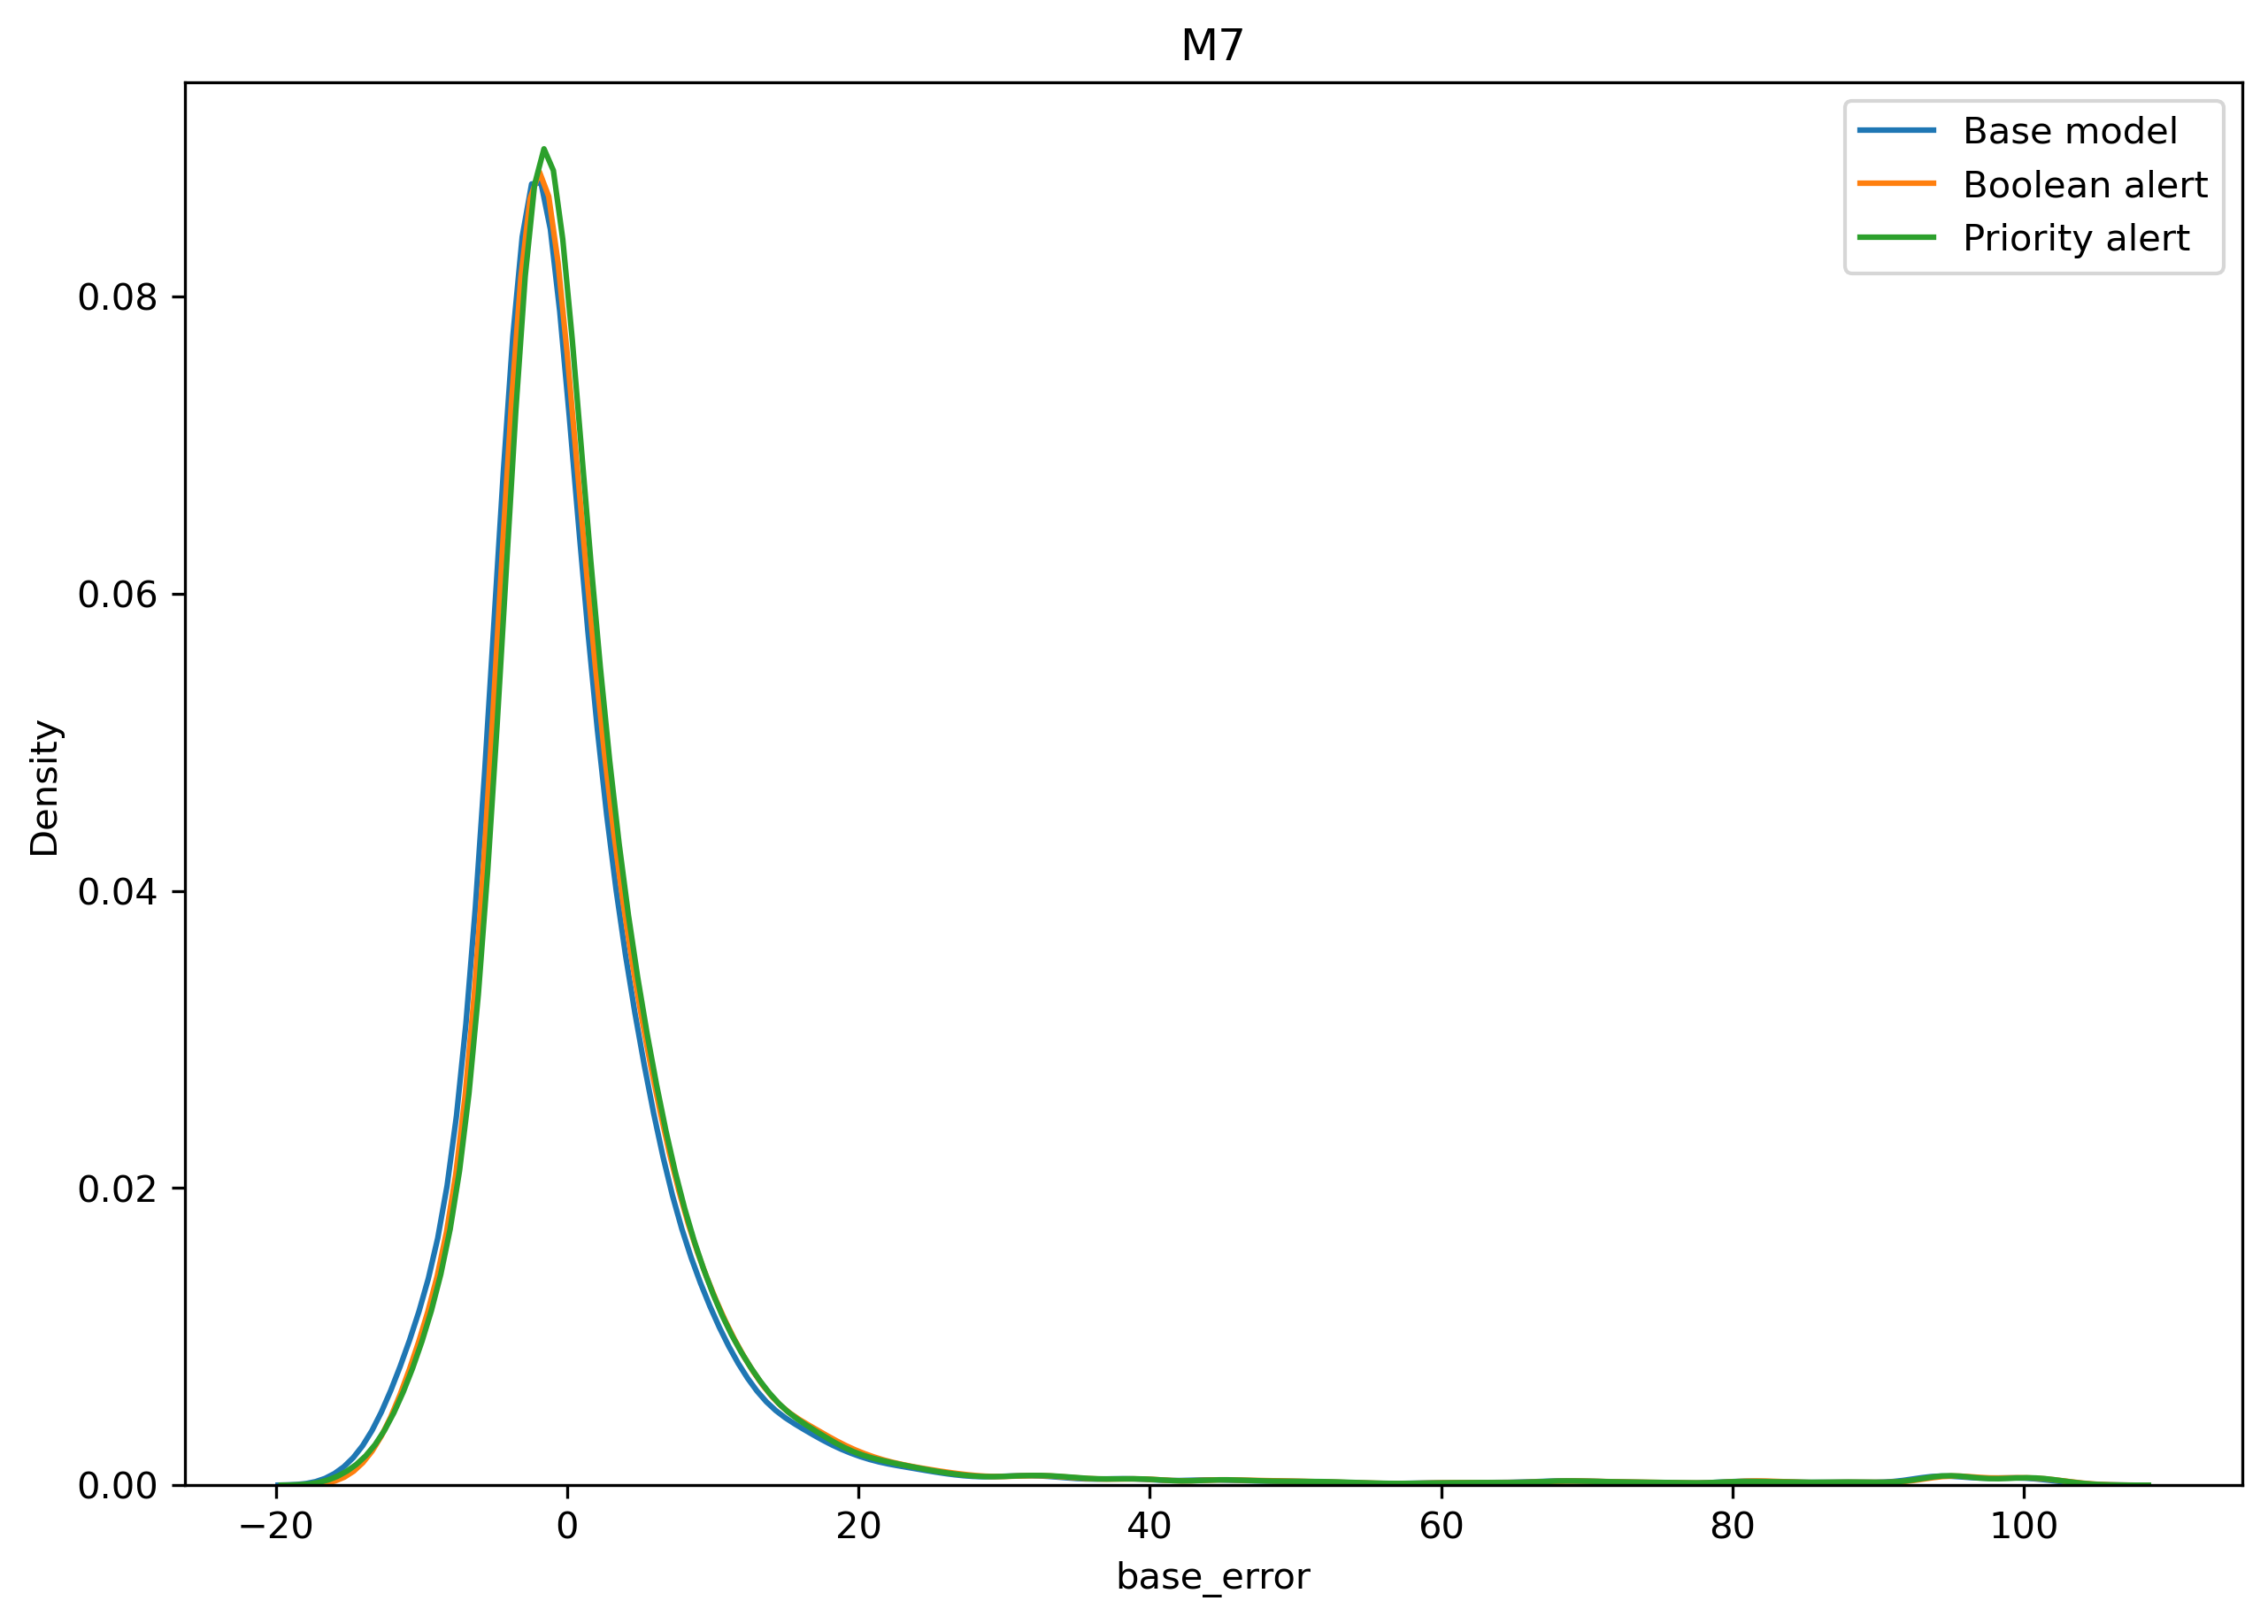

In [68]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 7), dpi=300)

sns.kdeplot(data=X_test_full, x="base_error", label="Base model")
sns.kdeplot(data=X_test_full, x="bool_error", label="Boolean alert")
sns.kdeplot(data=X_test_full, x="prio_error", label="Priority alert")
ax.legend()
ax.set_title("M7")

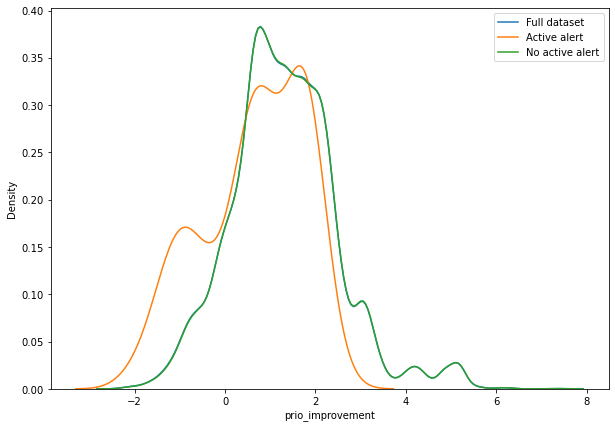

In [108]:
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)

sns.kdeplot(data=X_test_full, x="prio_improvement", label = "Full dataset")
sns.kdeplot(data=X_test_full[X_test_full.alert_ind == 1], x="prio_improvement", label = "Active alert")
sns.kdeplot(data=X_test_full[X_test_full.alert_ind == 0], x="prio_improvement", label = "No active alert")
ax.legend()

In [103]:
(
    X_test_full[X_test_full.alert_ind == 1].prio_improvement.mean(),
    X_test_full[X_test_full.alert_ind == 0].prio_improvement.mean()
)

(0.6411470770835876, 1.3153860569000244)

## When alerts are active, do we underpredict?

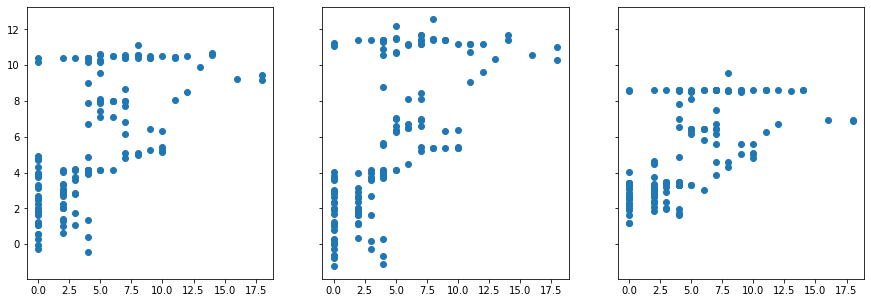

In [105]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

X_test_alert = X_test_full[X_test_full.alert_ind == 1]

axs[0].scatter(X_test_alert.y_test, X_test_alert.y_pred_base)
axs[1].scatter(X_test_alert.y_test, X_test_alert.y_pred_bool)
axs[2].scatter(X_test_alert.y_test, X_test_alert.y_pred_prio)

**Yes, and neither of the inclusions of alert data seems to improve this fact**

## When alerts are active, do we underpredict more than in similar situations?

# Experiment: using lower and upper bounds



In [435]:
# log cosh quantile is a regularized quantile loss function
def log_cosh_quantile(alpha):
    def _log_cosh_quantile(y_true, y_pred):
        err = y_pred - y_true
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)
        grad = np.tanh(err)
        hess = 1 / np.cosh(err)**2
        return grad, hess
    return _log_cosh_quantile

In [468]:
alpha = 0.95

In [469]:
model = XGBRegressor(objective=log_cosh_quantile(alpha),
                       n_estimators=125,
                       max_depth=5,
                       n_jobs=6,
                       learning_rate=.05)

In [470]:
model.fit(X_train_base, y_train_base)

<ipython-input-435-ec4161e2d7d6>:7: RuntimeWarning: overflow encountered in cosh
  hess = 1 / np.cosh(err)**2
<ipython-input-435-ec4161e2d7d6>:7: RuntimeWarning: overflow encountered in square
  hess = 1 / np.cosh(err)**2


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=125, n_jobs=6,
             num_parallel_tree=1,
             objective=<function log_cosh_quantile.<locals>._log_cosh_quantile at 0x15490f8b0>,
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [471]:
y_upper_smooth = model.predict(X_test_base)

In [472]:
model = XGBRegressor(objective=log_cosh_quantile(1-alpha),
                       n_estimators=125,
                       max_depth=5,
                       n_jobs=6,
                       learning_rate=.05)

In [473]:
model.fit(X_test_base, y_test_base)
y_lower_smooth = model.predict(X_test_base)

In [474]:
X_test_base_lu = X_test_base.copy()

In [475]:
X_test_base_lu['lower'] = y_lower_smooth
X_test_base_lu['upper'] = y_upper_smooth
X_test_base_lu['y_test'] = y_test_base

In [476]:
def is_within_bounds(row):
    lower = row.lower
    upper = row.upper
    y_test = row.y_test
    if lower <= y_test <= upper:
        return True
    else:
        return False

In [478]:
X_test_base_lu['correct'] = X_test_base_lu.apply(is_within_bounds, axis=1)

In [479]:
X_test_base_lu.correct.sum() / X_test_base_lu.correct.count()

0.3779542192807657

In [486]:
X_test_base

,direction,next_stop,lat,lon,hour,day,dow
374489,1,125,40.650328,-73.894332,0,16,1
374490,1,98,40.613789,-73.981462,0,16,1
374494,1,106,40.632499,-73.918642,0,16,1
374496,1,95,40.616830,-73.978283,0,16,1
374497,0,20,40.619278,-73.976383,0,16,1
...,...,...,...,...,...,...,...
501596,0,118,40.657750,-73.878915,4,22,0
501598,1,62,40.653146,-73.889566,4,22,0
501599,0,119,40.658488,-73.877714,4,22,0
501602,1,88,40.634244,-73.949158,4,22,0


<AxesSubplot:>

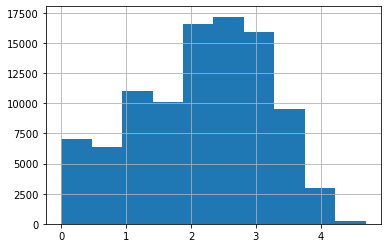

In [483]:
np.log(X_test_base_lu.y_test).hist()